In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, median_absolute_error, mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


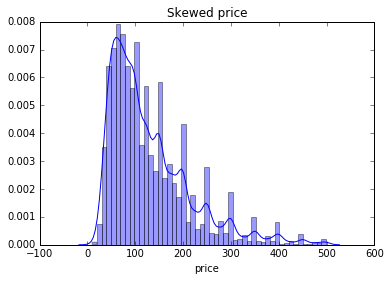

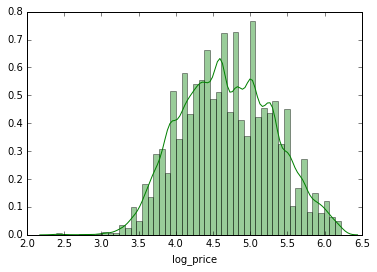

In [3]:
# DATA CLEANING


# Load the dataset
dataset = pd.read_csv('data/AB_NYC_2019.csv')

# Drop unwanted columns
dataset.drop('id', axis=1, inplace=True)
dataset.drop('name', axis=1, inplace=True)
dataset.drop('host_id', axis=1, inplace=True)
dataset.drop('host_name', axis=1, inplace=True)
dataset.drop('number_of_reviews', axis=1, inplace=True)
dataset.drop('last_review', axis=1, inplace=True)
dataset.drop('reviews_per_month', axis=1, inplace=True)
dataset.drop('latitude', axis=1, inplace=True)
dataset.drop('longitude', axis=1, inplace=True)

# Remove price = 0
dataset = dataset[dataset.price > 0].copy()[dataset.price < 500].copy()

# Standardize ratio attributes
dataset[['minimum_nights', 'calculated_host_listings_count', 'availability_365']] = StandardScaler().fit_transform(dataset[['minimum_nights', 'calculated_host_listings_count', 'availability_365']])

# Log price
dataset['log_price'] = np.log1p(dataset['price'])

# One hot encoding for the categorical features
neighbourhood_group_dummies = pd.get_dummies(dataset['neighbourhood_group'], prefix="is_group")
room_type_dummies = pd.get_dummies(dataset['room_type'], prefix="is_room")
neighbourhood_dummies = pd.get_dummies(dataset['neighbourhood'], prefix="is_neighbourhood")
preprocessed_dataset = pd.concat([dataset[['minimum_nights','calculated_host_listings_count',
       'availability_365']], room_type_dummies, neighbourhood_group_dummies, neighbourhood_dummies, dataset[['price', 'log_price']]], axis=1)

# plots
sb.distplot(preprocessed_dataset['price'], color='blue')
plt.title('Skewed price')
plt.show()

sb.distplot(preprocessed_dataset['log_price'], color='green')
plt.show()

In [4]:
# DIMENSIONALILTY REDUCTION

# Principle Component Analysis
X = preprocessed_dataset.copy().drop('price', axis=1).drop('log_price', axis=1)
y = preprocessed_dataset['log_price']

print(X.shape, y.shape)
pca = PCA()
pca.fit(X)

cutoff_variance = 0.99 # 0.98 # 0.95
cutoff = 0
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumulative_variance)):
    if cumulative_variance[i] > cutoff_variance:
        cutoff = i
        break
        
print('cutoff =', cutoff)

pca = PCA(n_components=cutoff)
pcaX = pca.fit_transform(X)
pcaX.shape

# get the training and testing sets (PCA)
X_train, X_test, y_train, y_test = train_test_split(pcaX, y, test_size=0.25, random_state=100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(47649, 230) (47649,)
cutoff = 91
(35736, 91) (11913, 91) (35736,) (11913,)


In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth':6,
    'min_child_weight':1,
    'eta':0.3,
    'subsample':1,
    'colsample_bytree':1,
    'objective':'reg:squarederror',
    'eval_metric': 'rmse'
}

num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=10
)



/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	Test-rmse:2.97387
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:2.09946
[2]	Test-rmse:1.49523
[3]	Test-rmse:1.08233
[4]	Test-rmse:0.805816
[5]	Test-rmse:0.626919
[6]	Test-rmse:0.517898
[7]	Test-rmse:0.454438
[8]	Test-rmse:0.420108
[9]	Test-rmse:0.401259
[10]	Test-rmse:0.391942
[11]	Test-rmse:0.387157
[12]	Test-rmse:0.384795
[13]	Test-rmse:0.383705
[14]	Test-rmse:0.382924
[15]	Test-rmse:0.382519
[16]	Test-rmse:0.382273
[17]	Test-rmse:0.382176
[18]	Test-rmse:0.381947
[19]	Test-rmse:0.381807
[20]	Test-rmse:0.381674
[21]	Test-rmse:0.381508
[22]	Test-rmse:0.381472
[23]	Test-rmse:0.381275
[24]	Test-rmse:0.381187
[25]	Test-rmse:0.381047
[26]	Test-rmse:0.381052
[27]	Test-rmse:0.381129
[28]	Test-rmse:0.381003
[29]	Test-rmse:0.380896
[30]	Test-rmse:0.38081
[31]	Test-rmse:0.380827
[32]	Test-rmse:0.380796
[33]	Test-rmse:0.380494
[34]	Test-rmse:0.380436
[35]	Test-rmse:0.380428
[36]	Test-rmse:0.380181
[37]	Test-rmse:0.380277
[38]	Test-rmse:0.38031
[39]	Test-rmse:0.380314

In [7]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results['test-rmse-mean'].min()

0.3826834

In [8]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9, 12)
    for min_child_weight in range(5, 8)
]
min_rmse = float('Inf')
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print('md={}, mc={}'.format(max_depth, min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print('RMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight)
print(best_params)

md=9, mc=5


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


RMSE 0.38309059999999995 for 22 rounds
md=9, mc=6
RMSE 0.3833586 for 18 rounds
md=9, mc=7
RMSE 0.38291240000000004 for 18 rounds
md=10, mc=5
RMSE 0.383675 for 16 rounds
md=10, mc=6
RMSE 0.3839886 for 16 rounds
md=10, mc=7
RMSE 0.383856 for 18 rounds
md=11, mc=5
RMSE 0.38474159999999996 for 18 rounds
md=11, mc=6
RMSE 0.3849514 for 16 rounds
md=11, mc=7
RMSE 0.3847216 for 15 rounds
(9, 7)


In [9]:
params['max_depth'] = 9
params['min_child_weight'] = 7

In [10]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7, 11)]
    for colsample in [i/10. for i in range(7, 11)]
]
min_rmse = float('Inf')
best_params = None
for subsample, colsample in gridsearch_params:
    print('md={}, mc={}'.format(subsample, colsample))
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print('RMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample, colsample)
print(best_params)


md=0.7, mc=0.7


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


RMSE 0.3853324 for 16 rounds
md=0.7, mc=0.8
RMSE 0.384575 for 15 rounds
md=0.7, mc=0.9
RMSE 0.38436939999999997 for 17 rounds
md=0.7, mc=1.0
RMSE 0.384683 for 17 rounds
md=0.8, mc=0.7
RMSE 0.38422000000000006 for 17 rounds
md=0.8, mc=0.8
RMSE 0.38361979999999996 for 19 rounds
md=0.8, mc=0.9
RMSE 0.3840584 for 16 rounds
md=0.8, mc=1.0
RMSE 0.3838716 for 17 rounds
md=0.9, mc=0.7
RMSE 0.383805 for 20 rounds
md=0.9, mc=0.8
RMSE 0.3831562 for 16 rounds
md=0.9, mc=0.9
RMSE 0.38366740000000005 for 18 rounds
md=0.9, mc=1.0
RMSE 0.38389619999999997 for 17 rounds
md=1.0, mc=0.7
RMSE 0.38268939999999996 for 18 rounds
md=1.0, mc=0.8
RMSE 0.383568 for 17 rounds
md=1.0, mc=0.9
RMSE 0.382785 for 21 rounds
md=1.0, mc=1.0
RMSE 0.38291240000000004 for 18 rounds
(1.0, 0.7)


In [11]:
params['subsample'] = 1
params['colsample_bytree'] = 0.7

In [12]:
min_rmse = float('Inf')
best_params = None
for eta in [0.3, 0.2, 0.1, 0.05, 0.01]:
    print('eta={}'.format(eta))
    params['eta'] = eta
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print('RMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print(best_params)

eta=0.3


KeyboardInterrupt: 

In [32]:
params['eta'] = 0.05

In [33]:
params

{'colsample': 1.0,
 'colsample_bytree': 0.8,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 11,
 'min_child_weight': 7,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [36]:
params['eval_metric'] = 'rmse'

In [37]:
params_original = {
    'max_depth':6,
    'min_child_weight':1,
    'eta':0.3,
    'subsample':1,
    'colsample_bytree':1,
    'objective':'reg:squarederror',
    'eval_metric': 'rmse'
}

num_boost_round = 999

model = xgb.train(
    params_original,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=10
)

[0]	Test-rmse:3.1227
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:2.20426
[2]	Test-rmse:1.56709
[3]	Test-rmse:1.13024
[4]	Test-rmse:0.834253
[5]	Test-rmse:0.640857
[6]	Test-rmse:0.518931
[7]	Test-rmse:0.446805
[8]	Test-rmse:0.406008
[9]	Test-rmse:0.384376
[10]	Test-rmse:0.373006
[11]	Test-rmse:0.367128
[12]	Test-rmse:0.363762
[13]	Test-rmse:0.362314
[14]	Test-rmse:0.360942
[15]	Test-rmse:0.360521
[16]	Test-rmse:0.360501
[17]	Test-rmse:0.360036
[18]	Test-rmse:0.359905
[19]	Test-rmse:0.359789
[20]	Test-rmse:0.359911
[21]	Test-rmse:0.360015
[22]	Test-rmse:0.359916
[23]	Test-rmse:0.359709
[24]	Test-rmse:0.359658
[25]	Test-rmse:0.359364
[26]	Test-rmse:0.359326
[27]	Test-rmse:0.359406
[28]	Test-rmse:0.359281
[29]	Test-rmse:0.359161
[30]	Test-rmse:0.359203
[31]	Test-rmse:0.359147
[32]	Test-rmse:0.359523
[33]	Test-rmse:0.359439
[34]	Test-rmse:0.359498
[35]	Test-rmse:0.359503
[36]	Test-rmse:0.359433
[37]	Test-rmse:0.359548
[38]	Test-rmse:0.359538
[39]	Test-rmse:0.35973

In [38]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=10
)

[0]	Test-rmse:4.22125
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:4.01229
[2]	Test-rmse:3.81385
[3]	Test-rmse:3.6255
[4]	Test-rmse:3.44657
[5]	Test-rmse:3.27662
[6]	Test-rmse:3.11539
[7]	Test-rmse:2.96226
[8]	Test-rmse:2.81691
[9]	Test-rmse:2.67891
[10]	Test-rmse:2.54804
[11]	Test-rmse:2.42376
[12]	Test-rmse:2.30577
[13]	Test-rmse:2.1938
[14]	Test-rmse:2.08765
[15]	Test-rmse:1.98685
[16]	Test-rmse:1.89121
[17]	Test-rmse:1.80066
[18]	Test-rmse:1.7148
[19]	Test-rmse:1.63325
[20]	Test-rmse:1.55603
[21]	Test-rmse:1.48286
[22]	Test-rmse:1.41366
[23]	Test-rmse:1.34804
[24]	Test-rmse:1.28598
[25]	Test-rmse:1.22718
[26]	Test-rmse:1.17158
[27]	Test-rmse:1.11908
[28]	Test-rmse:1.06935
[29]	Test-rmse:1.02256
[30]	Test-rmse:0.978191
[31]	Test-rmse:0.936465
[32]	Test-rmse:0.897022
[33]	Test-rmse:0.859929
[34]	Test-rmse:0.824967
[35]	Test-rmse:0.791985
[36]	Test-rmse:0.761037
[37]	Test-rmse:0.731793
[38]	Test-rmse:0.704369
[39]	Test-rmse:0.678751
[40]	Test-rmse:0.654742
[4

In [44]:
rows = []
y_train_pred = model.predict(dtrain)
y_pred = model.predict(dtest)

rows.append([np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))),
               r2_score(y_test, y_pred),
               median_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
               mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
               np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))),
               r2_score(y_train, y_train_pred),
               median_absolute_error(np.expm1(y_train), np.expm1(y_train_pred)),
               mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))])


In [45]:
table = pd.DataFrame(rows, columns=['Test RMSE', 'Test R2', 'Test MedianAE', 'Test MeanAE', 'Train RMSE', 'Train R2', 'Train MedianAE', 'Train MeanAE'])
table

,Test RMSE,Test R2,Test MedianAE,Test MeanAE,Train RMSE,Train R2,Train MedianAE,Train MeanAE
0,58.028941,0.567695,27.539997,40.655268,49.848806,0.707854,21.772232,33.995062
